Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane/n02109047_8090.jpg
Images/n02109047-Great_Dane/n02109047_875.jpg
Images/n02109047-Great_Dane/n02109047_888.jpg
Images/n02109047-Great_Dane/n02109047_906.jpg
Images/n02109047-Great_Dane/n02109047_9164.jpg
Images/n02109047-Great_Dane/n02109047_926.jpg
Images/n021090

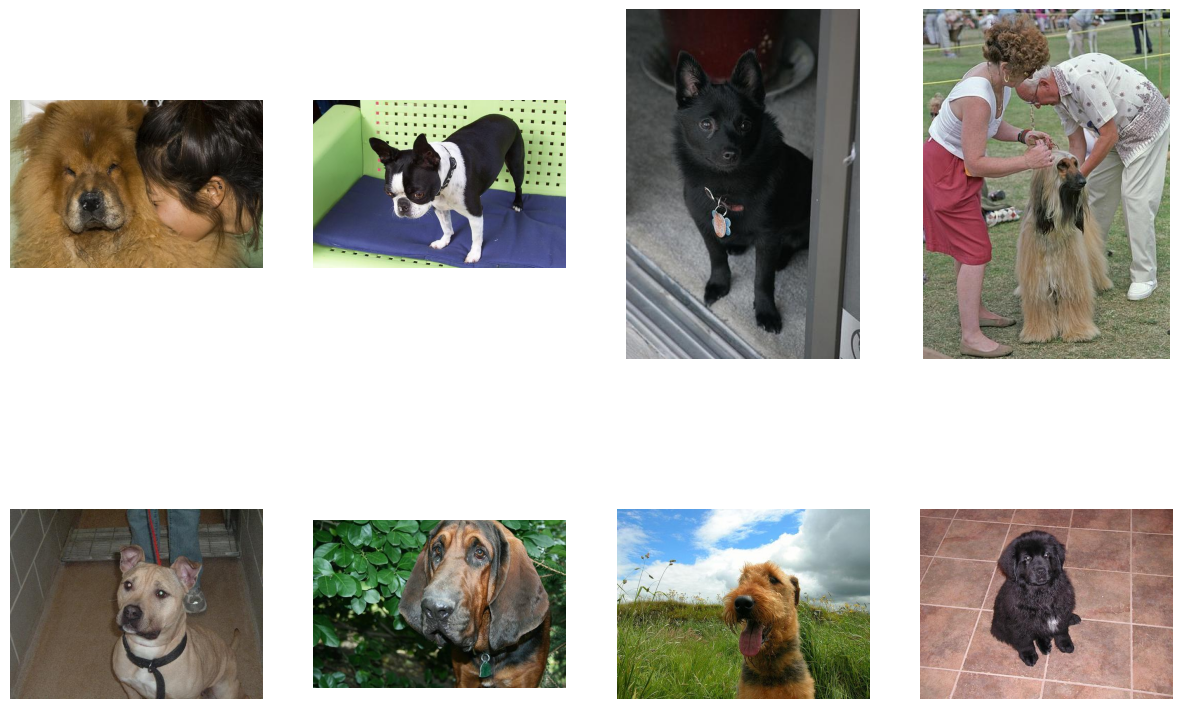

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Epoch [1/10], Loss: 0.8843
Epoch [2/10], Loss: 1.3199
Epoch [3/10], Loss: 0.8891
Epoch [4/10], Loss: 1.3171
Epoch [5/10], Loss: 1.0526
Epoch [6/10], Loss: 1.3027
Epoch [7/10], Loss: 1.6201
Epoch [8/10], Loss: 1.2293
Epoch [9/10], Loss: 1.3956
Epoch [10/10], Loss: 0.9987


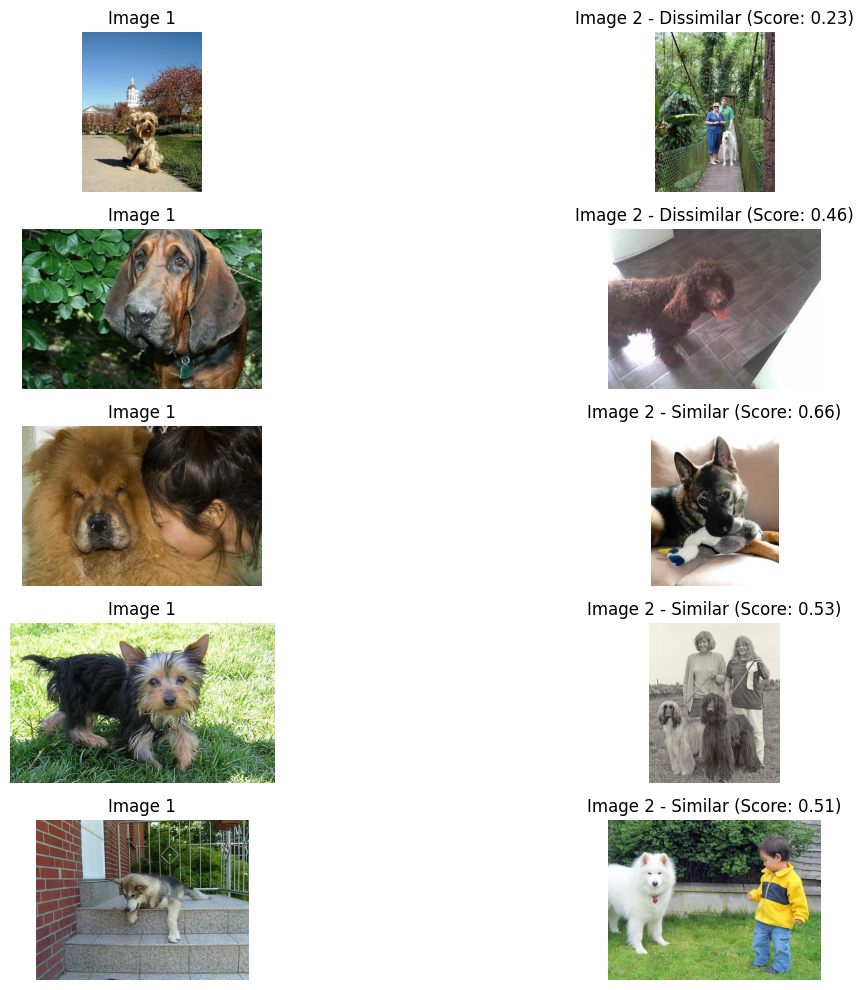

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import random
import pandas as pd
from torch.nn.functional import cosine_similarity

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download Stanford Dogs Dataset
!wget -qO- "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" | tar xvf - -C /content/sample_data

# Get list of images and select 64 images
image_paths = []
for root, dirs, files in os.walk('/content/sample_data/Images'):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

random.shuffle(image_paths)
image_paths = image_paths[:64]

# Step 2: Create DataFrame for the images
image_data = {'Image_Path': image_paths}
image_df = pd.DataFrame(image_data)
print(image_df.head())

# Step 3: Visualize some of the images
def visualize_images(image_paths, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_images(image_paths)

# Step 4: Dataset Preparation
class DogDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img, idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating Dataset and DataLoader
dataset = DogDataset(image_paths=image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 5: Develop a Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_cnn = models.resnet18(pretrained=True)
        self.base_cnn.fc = nn.Identity()  # Remove the last classification layer
        self.embedding_layer = nn.Linear(512, 128)  # Add embedding layer

    def forward(self, x):
        f = self.base_cnn(x)
        e = self.embedding_layer(f)
        return e

# Step 6: Loss Function and Optimizer
model = SiameseNetwork().to(device)
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 7: Training the Model
def train(model, dataloader, criterion, optimizer, epochs=10):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if len(imgs) < 3:
                continue  # Skip batches with less than 3 images
            batch_size = len(imgs) // 3 * 3  # Make sure the batch size is divisible by 3
            imgs = imgs[:batch_size]  # Trim the batch size to be divisible by 3
            img1, img2, img3 = imgs[0::3], imgs[1::3], imgs[2::3]  # Create triplets
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            optimizer.zero_grad()
            e1 = model(img1)
            e2 = model(img2)
            e3 = model(img3)

            loss = criterion(e1, e2, e3)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return loss_history

loss_history = train(model, dataloader, criterion, optimizer, epochs=10)

# Step 8: Plot Loss Curve
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Step 9: Visualize Model Output (Embeddings and Similarity Prediction)
def visualize_similarity(model, image_paths, num_pairs=5):
    model.eval()
    with torch.no_grad():
        plt.figure(figsize=(15, 10))
        for i in range(num_pairs):
            img1_path = random.choice(image_paths)
            img2_path = random.choice(image_paths)

            img1 = transform(Image.open(img1_path)).unsqueeze(0).to(device)
            img2 = transform(Image.open(img2_path)).unsqueeze(0).to(device)

            embedding1 = model(img1)
            embedding2 = model(img2)

            similarity = cosine_similarity(embedding1, embedding2)
            similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

            # Plot images side by side
            plt.subplot(num_pairs, 2, i * 2 + 1)
            plt.imshow(Image.open(img1_path))
            plt.axis('off')
            plt.title(f'Image 1')

            plt.subplot(num_pairs, 2, i * 2 + 2)
            plt.imshow(Image.open(img2_path))
            plt.axis('off')
            plt.title(f'Image 2 - {similarity_label} (Score: {similarity.item():.2f})')

        plt.tight_layout()
        plt.show()

visualize_similarity(model, image_paths, num_pairs=5)


Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane/n02109047_8090.jpg
Images/n02109047-Great_Dane/n02109047_875.jpg
Images/n02109047-Great_Dane/n02109047_888.jpg
Images/n02109047-Great_Dane/n02109047_906.jpg
Images/n02109047-Great_Dane/n02109047_9164.jpg
Images/n02109047-Great_Dane/n02109047_926.jpg
Images/n021090

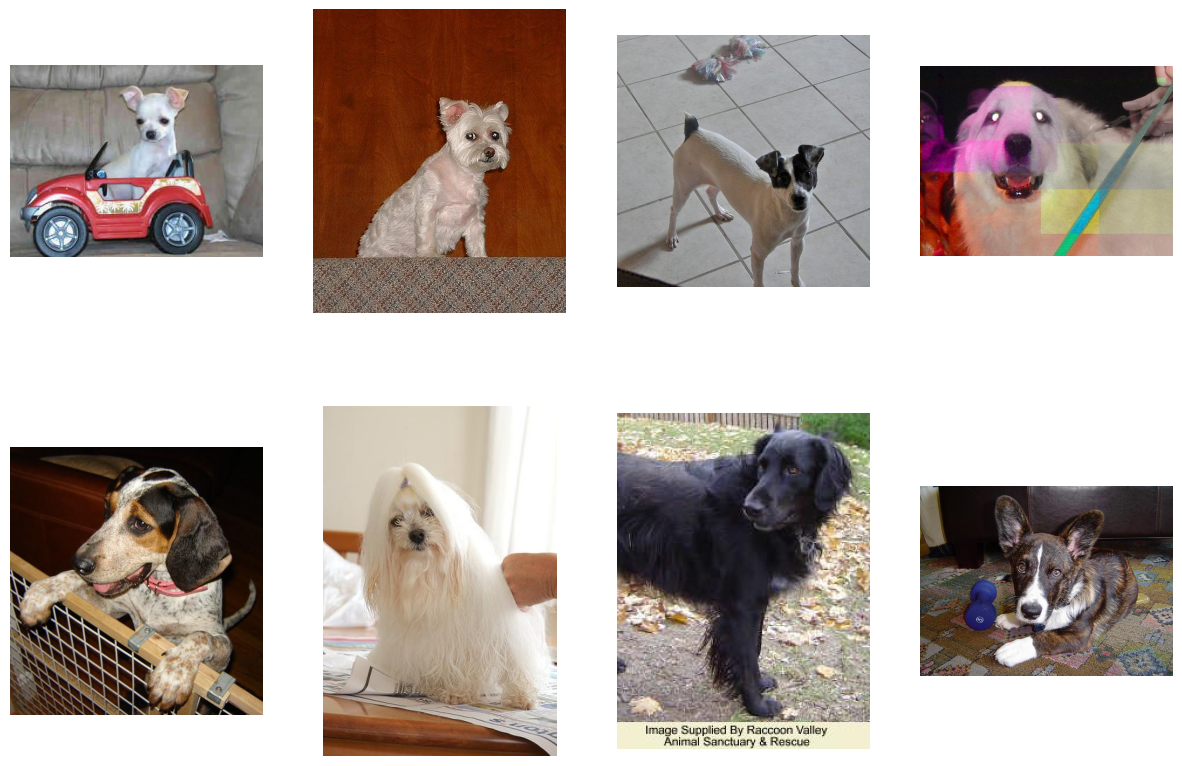

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9545
Epoch [2/10], Loss: 1.2590
Epoch [3/10], Loss: 1.1507
Epoch [4/10], Loss: 1.1602
Epoch [5/10], Loss: 1.4776
Epoch [6/10], Loss: 1.4009
Epoch [7/10], Loss: 1.1910
Epoch [8/10], Loss: 1.3892
Epoch [9/10], Loss: 1.3746
Epoch [10/10], Loss: 0.9965


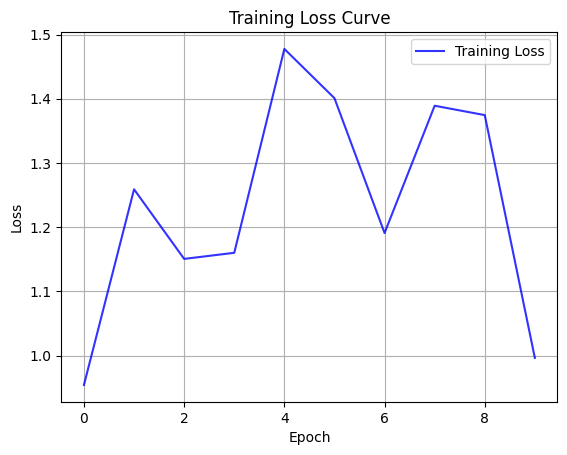

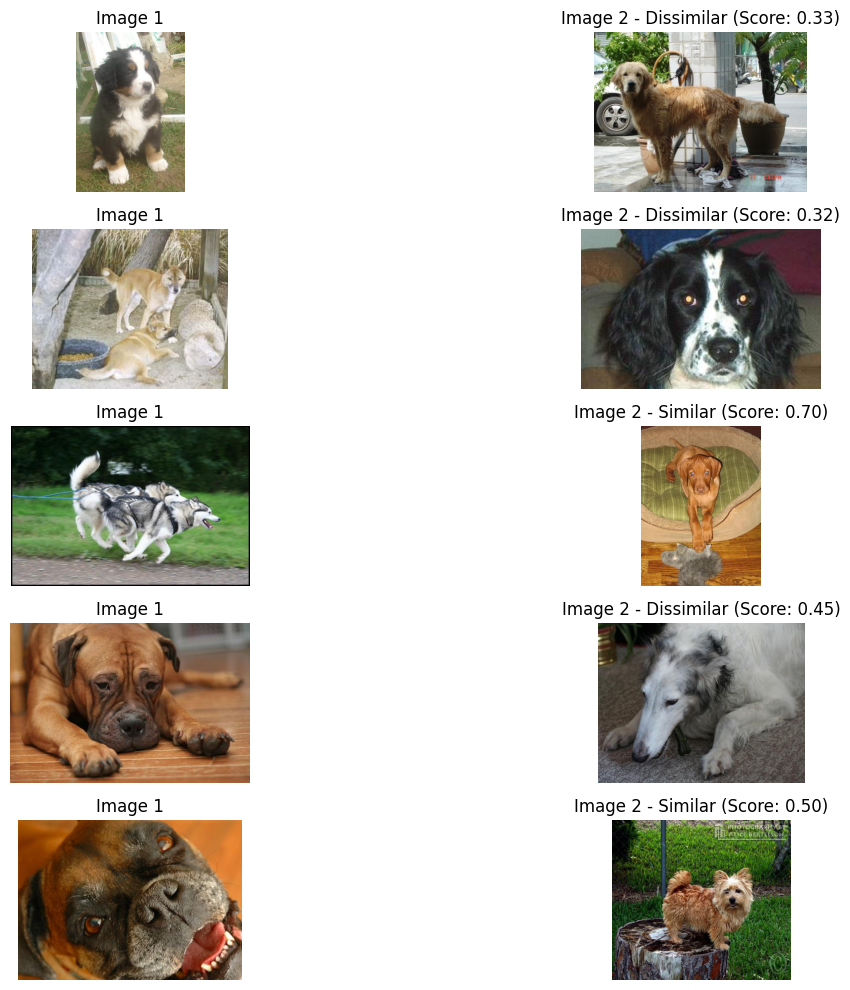

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import random
import pandas as pd
from torch.nn.functional import cosine_similarity

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download Stanford Dogs Dataset
!wget -qO- "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" | tar xvf - -C /content/sample_data

# Get list of images and select 64 images
image_paths = []
for root, dirs, files in os.walk('/content/sample_data/Images'):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

random.shuffle(image_paths)
image_paths = image_paths[:64]

# Step 2: Create DataFrame for the images
image_data = {'Image_Path': image_paths}
image_df = pd.DataFrame(image_data)
print(image_df.head())

# Step 3: Visualize some of the images
def visualize_images(image_paths, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_images(image_paths)

# Step 4: Dataset Preparation
class DogDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img, idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating Dataset and DataLoader
dataset = DogDataset(image_paths=image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 5: Develop a Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_cnn = models.resnet18(pretrained=True)
        self.base_cnn.fc = nn.Identity()  # Remove the last classification layer
        self.embedding_layer = nn.Linear(512, 128)  # Add embedding layer

    def forward(self, x):
        f = self.base_cnn(x)
        e = self.embedding_layer(f)
        return e

# Step 6: Loss Function and Optimizer
model = SiameseNetwork().to(device)
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Step 7: Training the Model with Smoother Loss Curve
def train(model, dataloader, criterion, optimizer, epochs=10):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if len(imgs) < 3:
                continue  # Skip batches with less than 3 images
            batch_size = len(imgs) // 3 * 3  # Make sure the batch size is divisible by 3
            imgs = imgs[:batch_size]  # Trim the batch size to be divisible by 3
            img1, img2, img3 = imgs[0::3], imgs[1::3], imgs[2::3]  # Create triplets
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            optimizer.zero_grad()
            e1 = model(img1)
            e2 = model(img2)
            e3 = model(img3)

            loss = criterion(e1, e2, e3)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return loss_history

loss_history = train(model, dataloader, criterion, optimizer, epochs=10)

# Step 8: Smooth Plot Loss Curve
plt.plot(loss_history, label='Training Loss', color='b', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Visualize Model Output (Embeddings and Similarity Prediction)
def visualize_similarity(model, image_paths, num_pairs=5):
    model.eval()
    with torch.no_grad():
        plt.figure(figsize=(15, 10))
        for i in range(num_pairs):
            img1_path = random.choice(image_paths)
            img2_path = random.choice(image_paths)

            img1 = transform(Image.open(img1_path)).unsqueeze(0).to(device)
            img2 = transform(Image.open(img2_path)).unsqueeze(0).to(device)

            embedding1 = model(img1)
            embedding2 = model(img2)

            similarity = cosine_similarity(embedding1, embedding2)
            similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

            # Plot images side by side
            plt.subplot(num_pairs, 2, i * 2 + 1)
            plt.imshow(Image.open(img1_path))
            plt.axis('off')
            plt.title(f'Image 1')

            plt.subplot(num_pairs, 2, i * 2 + 2)
            plt.imshow(Image.open(img2_path))
            plt.axis('off')
            plt.title(f'Image 2 - {similarity_label} (Score: {similarity.item():.2f})')

        plt.tight_layout()
        plt.show()

visualize_similarity(model, image_paths, num_pairs=5)


Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane/n02109047_8090.jpg
Images/n0

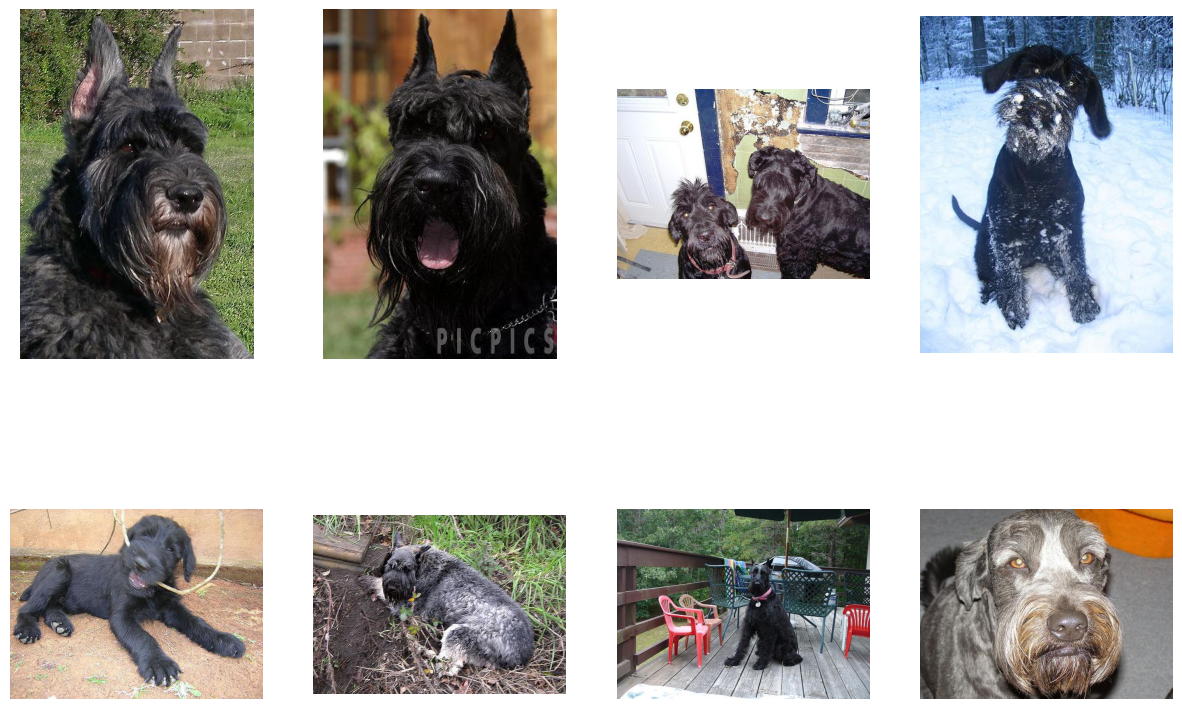

Epoch [1/10], Loss: 1.1322, Accuracy: 0.5043
Epoch [2/10], Loss: 1.0720, Accuracy: 0.5007
Epoch [3/10], Loss: 1.0284, Accuracy: 0.5061
Epoch [4/10], Loss: 1.0158, Accuracy: 0.5037
Epoch [5/10], Loss: 1.0308, Accuracy: 0.4911
Epoch [6/10], Loss: 1.0183, Accuracy: 0.5058
Epoch [7/10], Loss: 1.0153, Accuracy: 0.5103
Epoch [8/10], Loss: 1.0236, Accuracy: 0.4847
Epoch [9/10], Loss: 1.0124, Accuracy: 0.4928
Epoch [10/10], Loss: 1.0200, Accuracy: 0.4889


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import random
import pandas as pd


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download Stanford Dogs Dataset
!wget -qO- "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" | tar xvf - -C /content/sample_data

# Get list of all images
image_paths = []
for root, dirs, files in os.walk('/content/sample_data/Images'):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

# Step 2: Create DataFrame for the images
image_data = {'Image_Path': image_paths}
image_df = pd.DataFrame(image_data)
print(f'Total images: {len(image_df)}')

# Step 3: Visualize some of the images
def visualize_images(image_paths, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_images(image_paths)

# Step 4: Dataset Preparation
class DogDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating Dataset and DataLoader
dataset = DogDataset(image_paths=image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 5: Develop a Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_cnn = models.resnet18(pretrained=True)
        self.base_cnn.fc = nn.Identity()  # Remove the last classification layer
        self.embedding_layer = nn.Linear(512, 128)  # Add embedding layer

    def forward(self, x):
        f = self.base_cnn(x)
        e = self.embedding_layer(f)
        return e

# Step 6: Loss Function and Optimizer
model = SiameseNetwork().to(device)
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)



# Step 8: Training the Model
def train(model, dataloader, criterion, optimizer, epochs=10):
    loss_history = []
    accuracy_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if len(imgs) < 3:
                continue  # Skip batches with less than 3 images
            batch_size = len(imgs) // 3 * 3  # Make sure the batch size is divisible by 3
            imgs = imgs[:batch_size]  # Trim the batch size to be divisible by 3
            img1, img2, img3 = imgs[0::3], imgs[1::3], imgs[2::3]  # Create triplets
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            optimizer.zero_grad()
            e1 = model(img1)
            e2 = model(img2)
            e3 = model(img3)

            loss = criterion(e1, e2, e3)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            with torch.no_grad():
                dist_positive = torch.norm(e1 - e2, p=2, dim=1)
                dist_negative = torch.norm(e1 - e3, p=2, dim=1)
                correct += torch.sum(dist_positive < dist_negative).item()
                total += len(dist_positive)

        avg_loss = running_loss / len(dataloader)
        accuracy = correct / total
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return loss_history, accuracy_history

loss_history, accuracy_history = train(model, dataloader, criterion, optimizer, epochs=10)

# Step 9: Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

# Step 10: Visualize Model Output (Embeddings)
def visualize_embeddings(model, dataloader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, idx in dataloader:
            imgs = imgs.to(device)
            embedding = model(imgs)
            embeddings.append(embedding.cpu().numpy())
            labels.append(idx.numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title('Embedding Space Visualization')
    plt.show()

visualize_embeddings(model, dataloader)


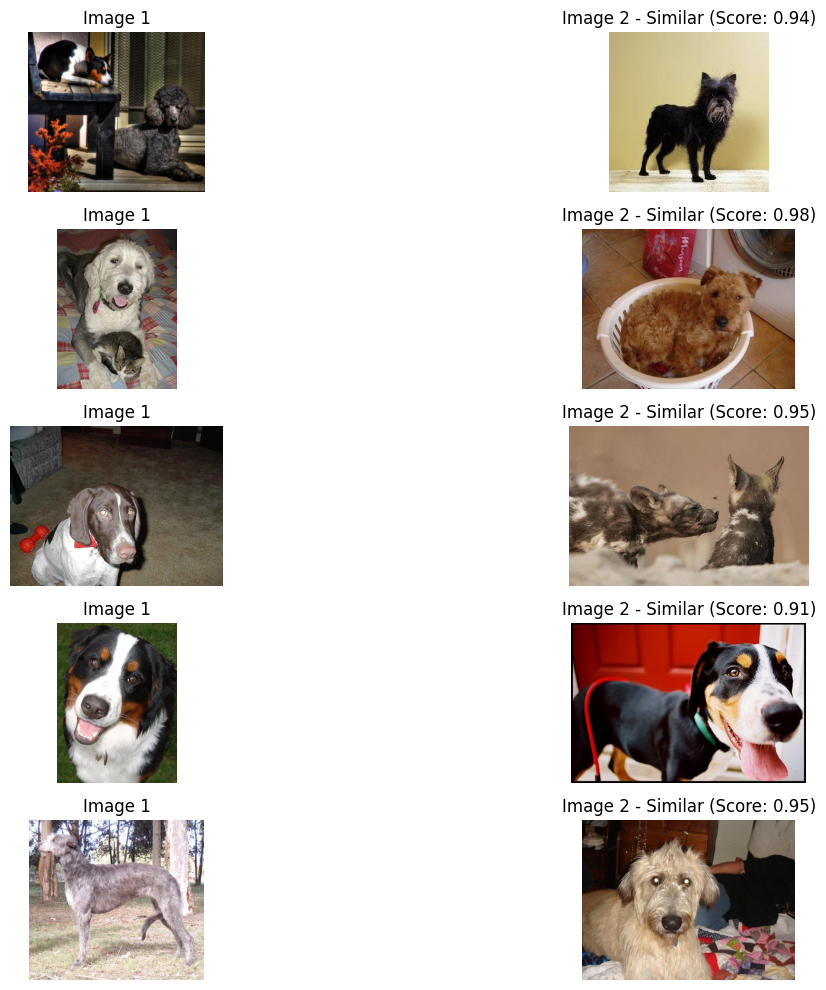

In [6]:
# Step 9: Visualize Model Output (Embeddings and Similarity Prediction)
def visualize_similarity(model, image_paths, num_pairs=5):
    model.eval()
    with torch.no_grad():
        plt.figure(figsize=(15, 10))
        for i in range(num_pairs):
            img1_path = random.choice(image_paths)
            img2_path = random.choice(image_paths)

            img1 = transform(Image.open(img1_path)).unsqueeze(0).to(device)
            img2 = transform(Image.open(img2_path)).unsqueeze(0).to(device)

            embedding1 = model(img1)
            embedding2 = model(img2)

            similarity = cosine_similarity(embedding1, embedding2)
            similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

            # Plot images side by side
            plt.subplot(num_pairs, 2, i * 2 + 1)
            plt.imshow(Image.open(img1_path))
            plt.axis('off')
            plt.title(f'Image 1')

            plt.subplot(num_pairs, 2, i * 2 + 2)
            plt.imshow(Image.open(img2_path))
            plt.axis('off')
            plt.title(f'Image 2 - {similarity_label} (Score: {similarity.item():.2f})')

        plt.tight_layout()
        plt.show()

visualize_similarity(model, image_paths, num_pairs=5)